# EECS731
## Project 2 - ToBeOrNotToBe

Classy Shakespeare plays and players

1. Set up a data science project structure in a new git repository in your GitHub account
2. Download the Shakespeare plays dataset from https://www.kaggle.com/kingburrito666/shakespeare-plays
3. Load the data set into panda data frames
4. Formulate one or two ideas on how feature engineering would help the data set to establish additional value using exploratory data analysis
5. Build one or more classification models to determine the player using the other columns as features
6. Document your process and results
7. Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub
<br>
***

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

from pandas import read_csv, concat, get_dummies

# plots
from matplotlib.pyplot import figure , imshow, axis, show
from seaborn import heatmap
from wordcloud import WordCloud, STOPWORDS

# Feature selection and engineering
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from nltk import tokenize, FreqDist, corpus
import nltk
nltk.download("stopwords")
nltk.download("punkt")
from scipy.sparse import csr_matrix, hstack
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

# make predictions
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /home/karen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/karen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = read_csv("../data/Shakespeare_data.csv")
df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111396 entries, 0 to 111395
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Dataline          111396 non-null  int64  
 1   Play              111396 non-null  object 
 2   PlayerLinenumber  111393 non-null  float64
 3   ActSceneLine      105153 non-null  object 
 4   Player            111389 non-null  object 
 5   PlayerLine        111396 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.1+ MB


***Let's look deeper at the datasets given***<br>
*column_name (type of column) 
    - description*

The shakespeare dataset contains the following columns :
- Dataline (int) ***seems useless***
    - A unique id for each line.
- Play (str) 
    - Name of the play where the lines are from
- PlayerLineNumber (int) 
    - The real line number that are being spoken 
    - Difference with ActSceneLine's Line
        - PlayerLineNumber is one whole long sentence and the ActSceneLine is the small cut part of PlayerLineNumber
        - PlayerLinenNumber resets in new scene
- ActSceneLine (str) 
    - Comes in 1.1.1 (Act is 1, Scene is 1, Line is 1)
    - ***Seperating them will be easier to use***
- Player (str)
    - The character name in the play
- PlayerLine (str)
    - The line spoken by the player 
<br><br>

- There seems to be a narrator ***problem***
***
## To determine the player using the other columns as features
We want to use the player column and find out if the line belongs to the player. ***(Predict what the player says depending on their lines)***
## Feature Engineering
- Transformation
    - 2. Play and player (make sure they are string first) needs to use one-hot encoding and label encoding
    - 5. Change all word in the PlayerLine to be lowercase and delete all punctuations.
    - 6. Bag of words playerline column 
- Selection
    - 3. Remove dataline
    - 1. Remove speech by narrator (We have to determine when the narrator speaks)
- Extraction
    - 4. Seperate ActSceneLine. Then delete ActSceneLine

*NOTE: The number is the order of how I did it*

***How do I know which line belongs to the narrator?***

In [4]:
df.head(3)

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."


In [5]:
df.iloc[[111,112,113],:]

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
111,112,Henry IV,10.0,NaN,WESTMORELAND,Exeunt
112,113,Henry IV,10.0,NaN,WESTMORELAND,SCENE II. London. An apartment of the Prince's.
113,114,Henry IV,10.0,NaN,WESTMORELAND,Enter the PRINCE OF WALES and FALSTAFF


By looking at the 2 output of dataset , narrator is when 
- ActSceneLine is NaN or 
- Player is NaN or
- PlayerLineNumber is NaN

In [6]:
# If any of columns in the subset list is NaN, we drop the row
df.dropna(subset=["ActSceneLine","Player","PlayerLinenumber"],inplace=True)
df.reset_index(drop=True,inplace=True)
df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
1,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"
2,6,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils
3,7,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.
4,8,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil


***Let's use Label Encoding for play and player and make sure they are type str*** <br>
*NOTE: Label Encoding will turn [dog,cat,dog,mouse,cat] into [1,2,1,3,2]* <br> 

In [7]:
# Label Encoding for play and player and make sure str
df['Play'] = LabelEncoder().fit_transform(df['Play'].astype(str))
df['Player'] = LabelEncoder().fit_transform(df['Player'].astype(str))

df.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,4,9,1.0,1.1.1,457,"So shaken as we are, so wan with care,"
1,5,9,1.0,1.1.2,457,"Find we a time for frighted peace to pant,"
2,6,9,1.0,1.1.3,457,And breathe short-winded accents of new broils
3,7,9,1.0,1.1.4,457,To be commenced in strands afar remote.
4,8,9,1.0,1.1.5,457,No more the thirsty entrance of this soil


After changing them to label, we should change see if there is any correlation between features to player

<AxesSubplot:>

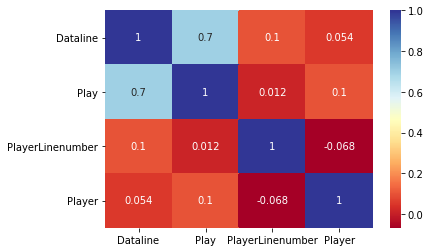

In [8]:
corr_matrix = df.corr()
corr_features = corr_matrix.index
heatmap(df[corr_features].corr(), annot=True, cmap="RdYlBu")

Even though play and dataline show high correlation (close to 1), it is still useless because it is just an unique id for each row. <br>***Let's delete Dataline!*** And continue cleaning

In [9]:
del df['Dataline']

***Seperating Act Scene and Line when there is '.'*** 

In [10]:
df_temp = df['ActSceneLine'].str.split('.', n=2, expand=True)
df["Act"] = df_temp[0].astype(int)
df["Scene"] = df_temp[1].astype(int)
df["Line"] = df_temp[2].astype(int)

df.head()

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine,Act,Scene,Line
0,9,1.0,1.1.1,457,"So shaken as we are, so wan with care,",1,1,1
1,9,1.0,1.1.2,457,"Find we a time for frighted peace to pant,",1,1,2
2,9,1.0,1.1.3,457,And breathe short-winded accents of new broils,1,1,3
3,9,1.0,1.1.4,457,To be commenced in strands afar remote.,1,1,4
4,9,1.0,1.1.5,457,No more the thirsty entrance of this soil,1,1,5


It looks great!<br> ***Let's delete the ActSceneLine :)***

In [11]:
del df["ActSceneLine"]

***Change playerline to lowercase and remove all punctuation***

In [12]:
# Remove all the punctuations in playerline col with regex
df["PlayerLine"] = df["PlayerLine"].str.replace(r'[^\w\s]', '').str.lower()
df.head()

,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,Line
0,9,1.0,457,so shaken as we are so wan with care,1,1,1
1,9,1.0,457,find we a time for frighted peace to pant,1,1,2
2,9,1.0,457,and breathe shortwinded accents of new broils,1,1,3
3,9,1.0,457,to be commenced in strands afar remote,1,1,4
4,9,1.0,457,no more the thirsty entrance of this soil,1,1,5


***Find the most frequent word in the dataset with nltk library***

In [13]:
txt = df.PlayerLine.str.cat(sep=' ')
words = tokenize.word_tokenize(txt)
freq_word = FreqDist(words)
freq_word.most_common(10)

[('the', 26004),
 ('and', 23389),
 ('i', 19889),
 ('to', 18122),
 ('of', 15429),
 ('you', 13316),
 ('a', 13312),
 ('my', 11864),
 ('that', 10399),
 ('in', 10214)]

All of it are stopwords (the,and,on,of,etc)<br>
***Another FreqDist without stopwords***

In [14]:
stopwords = corpus.stopwords.words('english')
freq_word_without_stopwords = FreqDist(word for word in words if word not in stopwords)
freq_word_without_stopwords.most_common(100)

[('thou', 5186),
 ('thy', 3726),
 ('shall', 3470),
 ('thee', 3018),
 ('good', 2706),
 ('lord', 2572),
 ('come', 2433),
 ('well', 2413),
 ('sir', 2369),
 ('would', 2243),
 ('let', 2019),
 ('ill', 1932),
 ('love', 1875),
 ('hath', 1842),
 ('man', 1746),
 ('one', 1706),
 ('go', 1677),
 ('upon', 1653),
 ('like', 1648),
 ('know', 1633),
 ('us', 1629),
 ('say', 1613),
 ('may', 1591),
 ('make', 1581),
 ('yet', 1514),
 ('must', 1463),
 ('see', 1375),
 ('tis', 1363),
 ('king', 1315),
 ('give', 1291),
 ('take', 1173),
 ('speak', 1131),
 ('mine', 1089),
 ('tell', 1038),
 ('much', 1001),
 ('think', 997),
 ('never', 990),
 ('time', 970),
 ('heart', 913),
 ('great', 868),
 ('hear', 861),
 ('art', 852),
 ('death', 833),
 ('men', 827),
 ('away', 814),
 ('doth', 809),
 ('life', 803),
 ('made', 797),
 ('father', 796),
 ('look', 787),
 ('hand', 780),
 ('ay', 762),
 ('thus', 739),
 ('true', 737),
 ('pray', 728),
 ('sweet', 717),
 ('god', 716),
 ('fair', 713),
 ('master', 698),
 ('day', 667),
 ('done', 647

***Lets double check the word frequency with wordcloud***

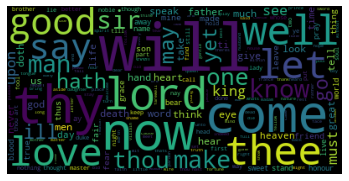

In [15]:
wordcloud = WordCloud(stopwords = STOPWORDS).generate(str(txt))
imshow(wordcloud)
axis('off')
show()

wordcloud seems to match our freq_word_without_stopwords

***Let's give numerical represention to PlayerLine col with Bag of words*** <br>
*NOTE: machine learning models dont know how to work with strings*

In [16]:
# Change vectorize 
count_vectorizer = CountVectorizer(max_df=5186, min_df=499, stop_words=stopwords, max_features=100) # to reduce dimensionality
vectorize_PlayerLine = count_vectorizer.fit_transform(df["PlayerLine"])
print(type(vectorize_PlayerLine))
vectorize_PlayerLine.toarray()

<class 'scipy.sparse.csr.csr_matrix'>


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

***What is max_df and min_df?*** <br>
***max_df*** is used for removing terms that appear too frequently, also known as "corpus-specific stop words". <br>
For example: <br>
***max_df*** = 0.50 means "ignore terms that appear in more than 50% of the documents". <br>
***max_df*** = 25 means "ignore terms that appear in more than 25 documents". <br>
The default ***max_df*** is 1.0, which means "ignore terms that appear in more than 100% of the documents". <br>
Thus, the default setting does not ignore any terms. <br>

***min_df*** is same but the opposite 

In [17]:
df_temp = df.loc[:, (df.columns != 'Player') & (df.columns != 'PlayerLine')]
df_temp.head()

,Play,PlayerLinenumber,Act,Scene,Line
0,9,1.0,1,1,1
1,9,1.0,1,1,2
2,9,1.0,1,1,3
3,9,1.0,1,1,4
4,9,1.0,1,1,5


In [18]:
X = hstack([csr_matrix(df_temp),vectorize_PlayerLine])
X # input

<105152x103 sparse matrix of type '<class 'numpy.float64'>'
	with 630873 stored elements in COOrdinate format>

In [19]:
Y = df.Player.values
Y # output

array([457, 457, 457, ..., 494, 494, 494])

***Use train_test_split to get the train and validation of X and Y***

In [20]:
df['PlayerLine'] = LabelEncoder().fit_transform(df['PlayerLine'])
X = df.loc[:, (df.columns != 'Player') ]
X_train, X_validation , Y_train, Y_validation = train_test_split(X, Y, test_size=0.2, random_state=1,shuffle=True)

In [21]:
def evaluate_model(name, model):
    model.fit(X_train, Y_train)
    prediction = model.predict(X_validation)
    acc_score = accuracy_score(Y_validation, prediction)
    print(f"{name}'s accuracy score is {acc_score}" )

In [22]:
def evaluate_model_with_cross_val(name,model,n_splits):
    kFold = StratifiedKFold(n_splits=n_splits, random_state=1, shuffle=True)
    prediction = cross_val_predict(model, X_train, Y_train, cv=kFold)
    acc_score = accuracy_score(Y_train, prediction)
    print(f"{name}'s accuracy score with cross validation (k={n_splits}) is {acc_score}" )    

## List of models and models name we want to fit and transform

In [23]:
models = []
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
models.append(('K Neighbour Classifier ', KNeighborsClassifier()))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Random Forest Classifier', RandomForestClassifier(n_estimators=100)))

In [24]:
for name, model in models:
    evaluate_model(name, model)

Decision Tree Classifier's accuracy score is 0.7222671294755361
Linear Discriminant Analysis's accuracy score is 0.10513052161095526
K Neighbour Classifier 's accuracy score is 0.022062669392801104
Gaussian Naive Bayes's accuracy score is 0.1757881222956588
Random Forest Classifier's accuracy score is 0.7620179734677381


Let's see if any of the model other than Random Forest Classifier will surpass the accuracy

In [25]:
for name, model in models[:4]:
    evaluate_model_with_cross_val(name, model,10)

Decision Tree Classifier's accuracy score with cross validation (k=10) is 0.7180490008440223
Linear Discriminant Analysis's accuracy score with cross validation (k=10) is 0.10719083225353955
K Neighbour Classifier 's accuracy score with cross validation (k=10) is 0.019840467897433458
Gaussian Naive Bayes's accuracy score with cross validation (k=10) is 0.17725657089192948


# Summary
Random forest has the highest accuracy